## 0. Wczytanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

In [2]:
def elbow_plot(model, data):
    visualizer = KElbowVisualizer(model, k = (2,15))
    visualizer.fit(data)
    visualizer.poof()
        
def silhouette_plot(model, data):
    visualizer = SilhouetteVisualizer(model, random_state = 10)
    visualizer.fit(data)
    visualizer.poof()

## 1. Wczytanie danych

In [3]:
df = pd.read_csv("Customers.csv")
df.head()

,CustomerId;Profit;Recency;Frequency;Monetary;Variance
1;187;63;1;2349,06;2
2;96;10;6;922,62;4
3;47;35;4;881,22;3
4;294;5;1;3815,16;2
5;732;4;31;41868,11;29


Mamy tu mały bałagan :) Widzimy jedną kolumnę, której nazwa i wartości są oddzielone średnikami. Musimy je rozdzielić. W tym celu skorzystamy z opcji 'delimiter'.

In [4]:
df2 = pd.read_csv("Customers.csv", delimiter = ";")
df2.sample(5)

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
376,377,444,3,21,"11420,25",24
770,771,245,11,4,"20805,98",21
67,68,3645,3,36,"73717,29",62
971,972,699,3,11,"31420,29",19
762,763,1259,3,9,"67930,2",31


Od razu inaczej :) Dowiedzmy się czegoś więcej o kolumnach, ich typach i wartościach.

## 2. Przegląd danych

In [5]:
df2.shape

(1511, 6)

Mamy 1511 wierszy i 6 kolumn.

In [6]:
df2.isnull().sum()

CustomerId    0
Profit        0
Recency       0
Frequency     0
Monetary      0
Variance      0
dtype: int64

Nie mamy pustych wartości, wszystkie wiersze są uzupełnione.

In [7]:
df2.dtypes

CustomerId     int64
Profit         int64
Recency        int64
Frequency      int64
Monetary      object
Variance       int64
dtype: object

Wszystkie kolumny z wyjątkiem "Monetary" zawierają liczny całkowite (integer). Kolumna "Monetary" jest typu 'object', którą możemy interpretować jako tekst (string). Zawiera ona liczby, ale są one interpretowane jako tekst. Należy zmienić typ tej kolumny na liczby zmiennoprzecinkowe (float).

## 3. Przygotowanie danych

### 3.1. Zmiana typu kolumny Monetary na float

Przekonwertujmy kolumnę "Monetary" na wartości liczbowe. W tym celu najpierw zamienimy przecinek na kropkę, bowiem to kropka oddziela w Pythonie część całkowitą od dziesiętnej. Skorzystamy z funkcji 'replace()'.

In [8]:
df3 = df2.copy()
df3.Monetary = df3.Monetary.replace(to_replace = ",", value = ".", regex = True)
df3.Monetary

0         2349.06
1          922.62
2          881.22
3         3815.16
4        41868.11
          ...    
1506     15798.92
1507      2676.89
1508    109497.54
1509     49602.45
1510      1047.58
Name: Monetary, Length: 1511, dtype: object

Nadal typ tej kolumny to 'object'. Zamieniamy typ na float za pomocą funkcji 'astype()'.

In [9]:
df3.Monetary = df3.Monetary.astype(float)
df3.dtypes

CustomerId      int64
Profit          int64
Recency         int64
Frequency       int64
Monetary      float64
Variance        int64
dtype: object

Teraz wszystkie kolumny reprezentują liczby.

### 3.2. Usunięcie kolumny CustomerID

In [10]:
df3.head()

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
0,1,187,63,1,2349.06,2
1,2,96,10,6,922.62,4
2,3,47,35,4,881.22,3
3,4,294,5,1,3815.16,2
4,5,732,4,31,41868.11,29


Kolumna "CustomerId" określa konkretnego klienta. Z punktu widzenia naszych danych i późniejszej segmentacji jest ona nieistotna. Nie niesie żadnych przydatnych informacji. Usuniemy ją.

In [11]:
df3 = df3.drop("CustomerId", axis = 1)

### 3.3. Rozkład danych

Teraz sprawdźmy jak prezentuje się rozkład naszych danych.

In [12]:
round(df3.describe(), 2)

,Profit,Recency,Frequency,Monetary,Variance
count,1511.00,1511.00,1511.00,1511.00,1511.00
mean,1102.39,15.85,10.71,175380.50,16.67
std,5457.68,19.05,10.35,1791089.38,17.70
min,1.00,1.00,1.00,7.29,1.00
25%,79.00,4.00,3.00,1392.95,5.00
50%,224.00,6.00,9.00,5799.93,11.00
75%,559.50,19.00,14.50,22289.00,23.00
max,105993.00,91.00,79.00,32539936.23,139.00


Odchylenie standardowe większe lub zbliżone do średniej oraz duża różnica między trzecim kwantylem a maksymalną wartością wskazują na występowanie długiego prawego ogona. Na wykresach będzie lepiej widać ;)

<AxesSubplot:xlabel='Recency', ylabel='Count'>

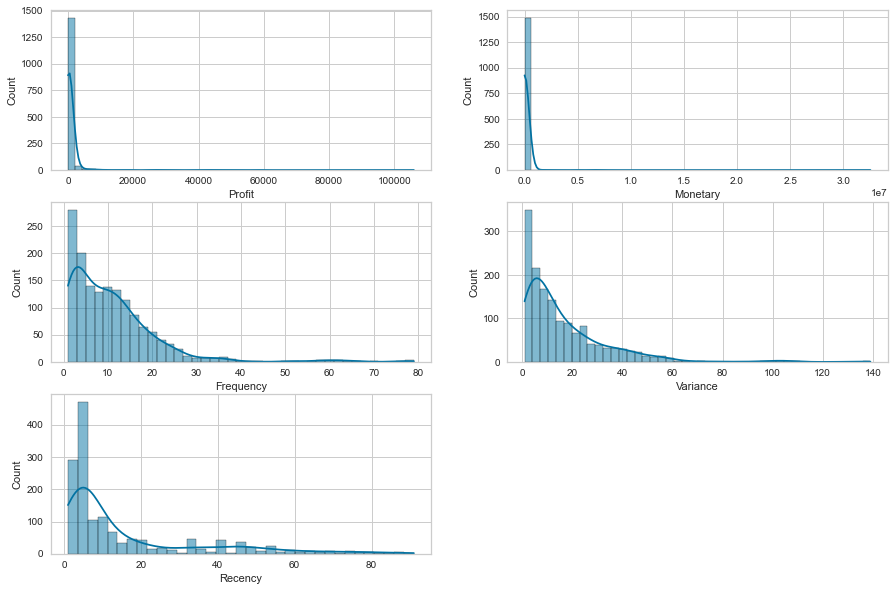

In [13]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.histplot(x = df3.Profit, kde = True, bins = 50)
plt.subplot(3,2,2)
sns.histplot(x = df3.Monetary, kde = True, bins = 50)
plt.subplot(3,2,3)
sns.histplot(x = df3.Frequency, kde = True)
plt.subplot(3,2,4)
sns.histplot(x = df3.Variance, kde = True)
plt.subplot(3,2,5)
sns.histplot(x = df3.Recency, kde = True)

Istotnie, "rozstrzał" jest bardzo duży. Aby go zniwelować, zlogarytmizujemy nasze dane. Możemy to zrobić, ponieważ wszystkie wartości w kolumnach są dodatnie.

#### 3.3.1. Logarytmizacja

In [14]:
df3_log = np.log(df3)

<AxesSubplot:xlabel='Recency', ylabel='Count'>

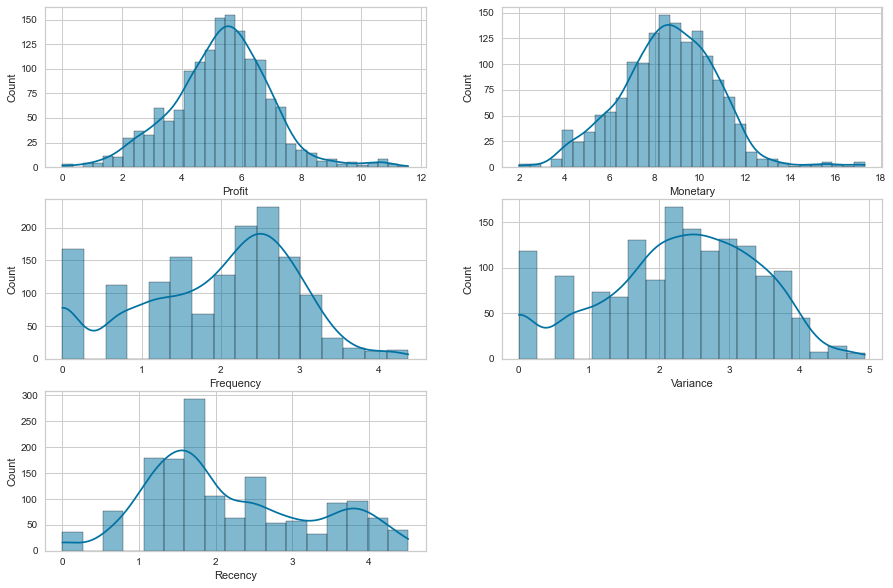

In [15]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.histplot(x = df3_log.Profit, kde = True)
plt.subplot(3,2,2)
sns.histplot(x = df3_log.Monetary, kde = True)
plt.subplot(3,2,3)
sns.histplot(x = df3_log.Frequency, kde = True)
plt.subplot(3,2,4)
sns.histplot(x = df3_log.Variance, kde = True)
plt.subplot(3,2,5)
sns.histplot(x = df3_log.Recency, kde = True)

Wygląda jako tako :) Pozbyliśmy się długich ogonów, a rozkłady przypominają rozkład normalny. Sprawdźmy, czy występują outliersy.

#### 3.3.2. Usuwanie wartości odstających

<AxesSubplot:xlabel='Recency'>

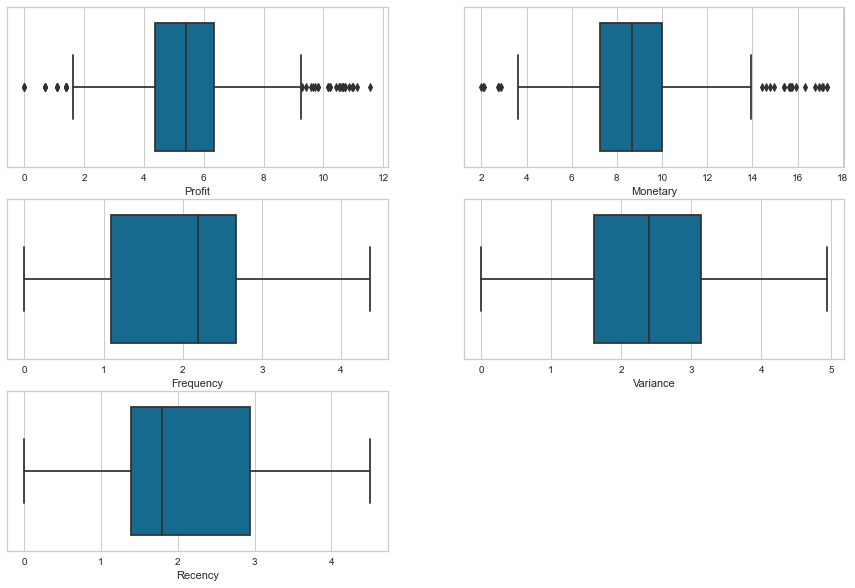

In [16]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.boxplot(x = df3_log.Profit)
plt.subplot(3,2,2)
sns.boxplot(x = df3_log.Monetary)
plt.subplot(3,2,3)
sns.boxplot(x = df3_log.Frequency)
plt.subplot(3,2,4)
sns.boxplot(x = df3_log.Variance)
plt.subplot(3,2,5)
sns.boxplot(x = df3_log.Recency)

W kolumnach "Profit" i "Monetary" mamy wartości odstające. Usuniemy je.

In [17]:
for i in ["Profit", "Monetary"]:
    q1 = df3_log[f"{i}"].quantile(0.25)
    q3 = df3_log[f"{i}"].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    df3_log = df3_log[(df3_log[f"{i}"] > low) & (df3_log[f"{i}"] < high)]

#### 3.3.3. Standaryzacja

Na koniec pozostaje nam ustandaryzować dane (sprowadzić do wspólnej skali)

In [18]:
scaler = StandardScaler()
scaler.fit(df3_log)
df3_log_std = scaler.transform(df3_log)
df3_log_scaler = pd.DataFrame(data = df3_log_std, index = df3_log.index, columns = df3_log.columns)

Zobaczmy, jak teraz przedstawiają się nasze dane.

<AxesSubplot:xlabel='Recency', ylabel='Count'>

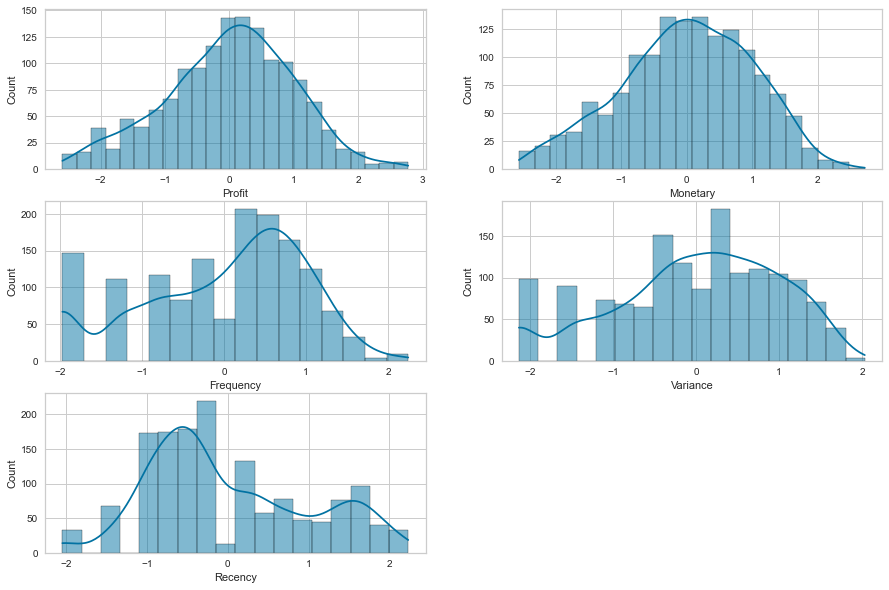

In [19]:
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
sns.histplot(x = df3_log_scaler.Profit, kde = True)
plt.subplot(3,2,2)
sns.histplot(x = df3_log_scaler.Monetary, kde = True)
plt.subplot(3,2,3)
sns.histplot(x = df3_log_scaler.Frequency, kde = True)
plt.subplot(3,2,4)
sns.histplot(x = df3_log_scaler.Variance, kde = True)
plt.subplot(3,2,5)
sns.histplot(x = df3_log_scaler.Recency, kde = True)

Teraz jest już OK. Możemy zauważyć bardzo duże podobieństwo rozkładu danych w kolumnach "Profit" i "Monetary" oraz w kolumnach "Frequency" i "Variance". Daje nam to przypuszczenie o zależnościach kolumn. Sprawdźmy korelacje między kolumnami.

#### 3.3.4. Koreacje

<AxesSubplot:>

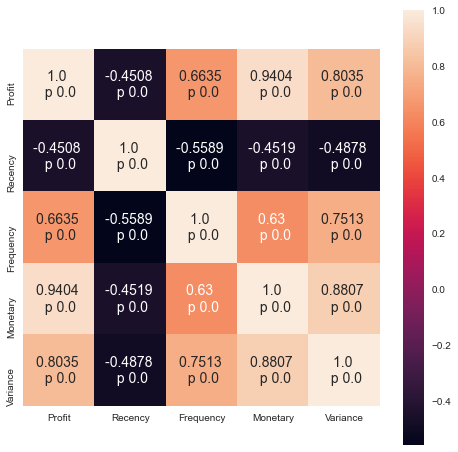

In [20]:
coef = np.around(stats.spearmanr(df3_log_scaler)[0], 4)   # Współczynniki korelacji Spearmana zaokrąglone do 4 miejsc po przecinku
pv = np.around(stats.spearmanr(df3_log_scaler)[1], 2)     # p-wartości zaokrąglone do 2 miejsc po przecinku

labels = np.asarray([f"{coef} \n p {pv}" for coef, pv in zip(coef.flatten(), pv.flatten())]).reshape(df3_log_scaler.shape[1], df3_log_scaler.shape[1])
plt.figure(figsize = (8,8))
sns.heatmap(coef, annot = labels, annot_kws = {'size': 14}, fmt = '', 
            xticklabels = df3_log.columns, yticklabels = df3_log.columns, square = True)

Wszędzie otrzymaliśmy p-wartości mniejsze niż 0,05, zatem możemy odrzucić hipotezę zerową o braku korelacji - nasze dane są skorelowane. Co więcej korelacja jest bardzo duża. Największe dotyczą kolumn:
- "Monetary" i "Profit" - im wyższa wartość zakupionych produktów, tym lepsza profitowość (Innymi słowy, im więcej klient zostawia kasy, tym lepiej :)
- "Variance" i "Monetary" - im więcej różnorodnych produktów klient kupił, tym wyższa wartość zakupionych produktów (logiczne :)
- "Variance" i "Profit" - im więcej różnorodnych produktów klient kupił, tym lepsza profitowość, co wynika z przechodniości powyższych implikacji.

Warto jeszcze wspomnieć o kolumnie "Recency". Jest ona ujemnie skorelowana z pozostałymi kolumnami. Oznacza to, że im mniej dni upłyneło od ostatniego zamówienia, tym większe pozostałe wskaźniki.

#### 3.3.5. Redukcja wymiarów (PCA)    (*bonus)

Przyda nam się do porównania segmentacji "danych oryginalnych" i "zredukowanych".

Uwaga! Przed redukcją wymiarów należy najpierw przeskalować dane (zrobiliśmy to w kroku [18])

In [21]:
pca = PCA(random_state = 10)
pca.fit_transform(df3_log_scaler)

np.cumsum(pca.explained_variance_ratio_)  # Procent skumulowanej wariancji wyznaczony przez k składowych

array([0.74844035, 0.88686227, 0.95806702, 0.99425409, 1.        ])

Dla naszych celów wystarczy, że zredukujemy dane do dwóch wymiarów (Procent skumulowanej wariancji 0,887)

In [22]:
pca = PCA(n_components = 2, random_state = 10)
df3_log_scaler_pca = pca.fit_transform(df3_log_scaler)

Zobaczmy jak wygląda rozkład kolumn na płaszczyźnie

In [23]:
column_names = df3_log_scaler.columns
df_pca = pd.DataFrame({"PCA 1": pca.components_[0], "PCA 2": pca.components_[1], "Features": column_names})
df_pca

,PCA 1,PCA 2,Features
0,-0.468734,0.355524,Profit
1,0.350849,0.822877,Recency
2,-0.442922,-0.237180,Frequency
3,-0.479537,0.355415,Monetary
4,-0.480685,0.117908,Variance


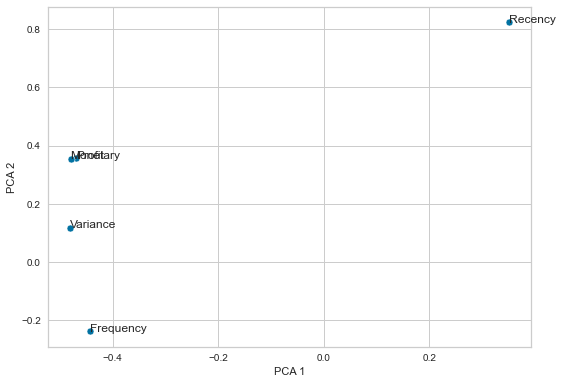

In [24]:
# Wykres

sns.scatterplot(x = df_pca["PCA 1"], y = df_pca["PCA 2"])
for i, txt in enumerate(df_pca.Features):
    plt.annotate(txt, (df_pca["PCA 1"][i], df_pca["PCA 2"][i]))
plt.tight_layout()
plt.show()

Wszystkie kolumny z wyjątkiem "Recency" mają zbliżoną pierwszą współrzędną PCA 1 - leżą na jednej prostej. Wynika to z korelacji tych kolumn - patrz heatmapa [20]. Kolumny "Profit" i "Monetary" prawie pokrywają się - są bardzo mocno skorelowane. Kolumna "Recency" bardzo odbiega współrzędną PCA 1 od reszty kolumn (jest z nimi silnie, ujemnie skorelowana). Najsilniej skorelowana jest z "Frequency", dlatego jest od niej najbardziej oddalona na wykresie.

## 4. Segmentacja

Za pomocą segmentacji sprawdzimy jak wygląda struktura danych wejściowych oraz czy występuje w nich czynnik pozwalający na ich  grupowanie. Jest to jedna z metod nienadzorowanej analizy danych (w odróżnieniu od klasyfikacji). Jej celem jest podział danych na klastry (grupy), tak aby każdy z nich zawierał możliwie „podobne do siebie” elementy (homogeniczność w grupach), a jednocześnie aby były one jak najbardziej zróżnicowane pomiędzy sobą (heterogeniczność pomiędzy grupami).

Algorytmy jakich użyjemy:
- KMeans
- Birch
- AgglomerrativeClastering
- Segmentacja hierarchiczna

Dodatkowo w bonusie przeprowadzimy segmentację na zredukowanych za pomocą PCA danych używając wyżej wymienionych algorytmów.

### 4.1. KMeans

Sprawdzimy, na ile grup można podzielić nasze dane w sposób najbardziej efektywny. W tym celu skorzystamy z tzw. metody łokcia.

In [25]:
distortion_score = []    # Suma kwadratów odległości danych od środka grupy dla poszczególnych k
cluster_range = range(1, 15)
for i in cluster_range:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df3_log_scaler)
    distortion_score.append(kmeans.inertia_)

Text(0, 0.5, 'distortion score')

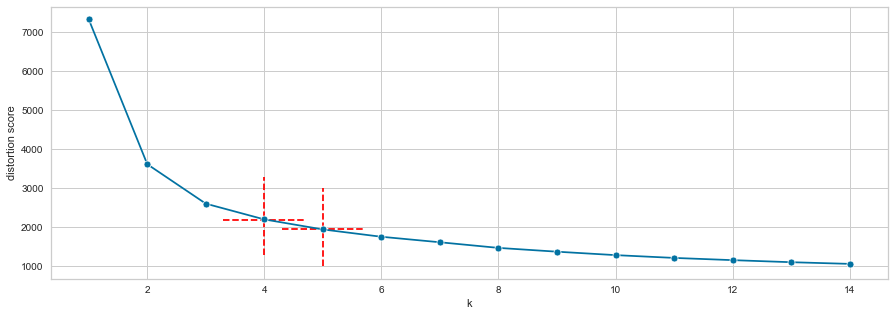

In [26]:
# Wykres łokcia

plt.figure(figsize = (15,5))
sns.lineplot(x = cluster_range, y = distortion_score, marker = "o")
plt.vlines(x = 5, ymin = 1000, ymax = 3000, linestyles = "dashed", colors = "red")
plt.vlines(x = 4, ymin = 1300, ymax = 3300, linestyles = "dashed", colors = "red")
plt.hlines(y = 1947, xmin = 4.3, xmax = 5.7,linestyles = "dashed", colors = "red")
plt.hlines(y = 2200, xmin = 3.3, xmax = 4.7,linestyles = "dashed", colors = "red")
plt.xlabel("k")
plt.ylabel("distortion score")

Hmmm, trudno stwierdzić :/ Mamy dwóch kandydatów: k = 4 i k = 5. Sprawdzimy, co nam powie algorytm 'KElbowVisualizer()'. 

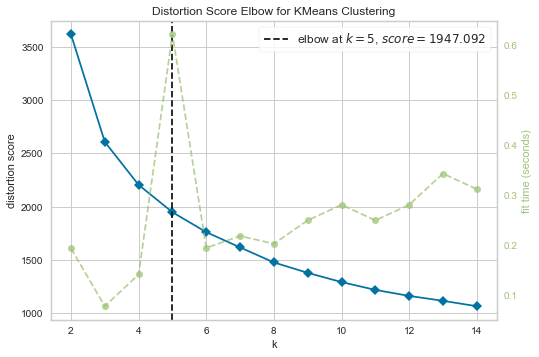

In [27]:
elbow_plot(KMeans(), df3_log_scaler)

Algorytm wskazał k = 5 jako najlepszy. Zatem nasze dane podzielimy na 5 grup.

Zobaczmy, jak będzie rozkład grup. W tym celu użyjemy 'SilhouetteVisualizer()'

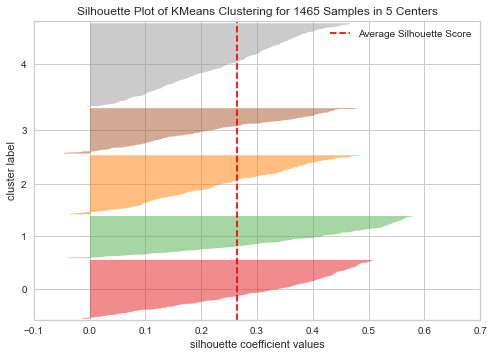

In [28]:
kmeans = KMeans(n_clusters = 5, random_state = 10)
kmeans.fit(df3_log_scaler)
silhouette_plot(kmeans, df3_log_scaler)

Uśredniony silhouette score niezbyt duży.

In [29]:
k_means_silhouette_avg = silhouette_score(df3_log_scaler, kmeans.labels_)
k_means_silhouette_avg

0.2643613359576207

In [30]:
kmeans_sum = pd.Series(kmeans.labels_).value_counts()
kmeans_sum

4    423
2    300
0    298
3    230
1    214
dtype: int64

Algorytm podzielił dane mniej więcej po równo.

### 4.2. KMeans PCA   (*bonus)

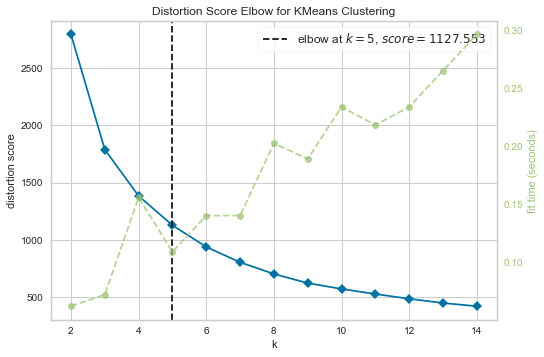

In [31]:
elbow_plot(KMeans(), df3_log_scaler_pca)

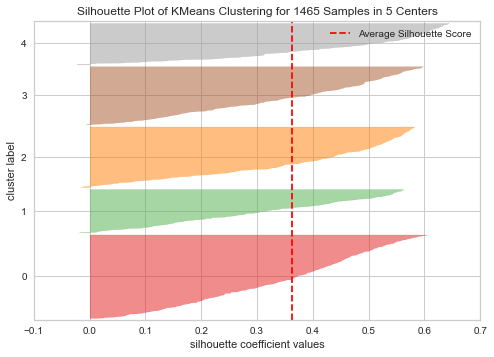

In [32]:
kmeans_pca = KMeans(n_clusters = 5, random_state = 10)
kmeans_pca.fit(df3_log_scaler_pca)
silhouette_plot(kmeans_pca, df3_log_scaler_pca)

Lepszy wynik silhouette niż wyżej.

In [33]:
k_means_pca_silhouette_avg = silhouette_score(df3_log_scaler_pca, kmeans_pca.labels_)
k_means_pca_silhouette_avg

0.3627609597598773

In [34]:
kmeans_pca_sum = pd.Series(kmeans_pca.labels_).value_counts()
kmeans_pca_sum

0    426
2    309
3    297
1    222
4    211
dtype: int64

Podobnie jak poprzednio

### 4.3. Birch

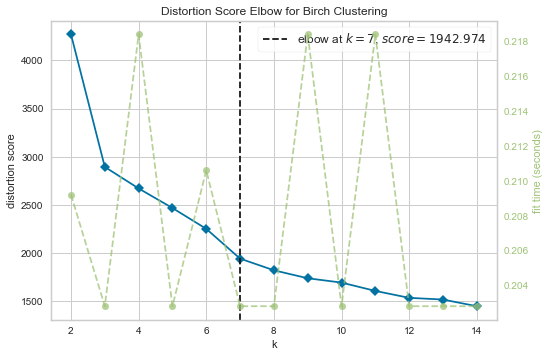

In [35]:
elbow_plot(Birch(), df3_log_scaler)

Algorytm wskazał k = 7 jako najlepszy. Zatem nasze dane podzielimy na 7 grup.

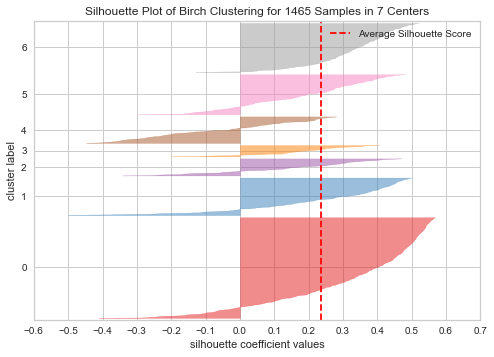

In [36]:
birch = Birch(n_clusters = 7)
birch.fit(df3_log_scaler)
silhouette_plot(birch, df3_log_scaler)

Dużo ujemnych współczynnkików silhouette. Nie jest to dobry model.

In [37]:
birch_silhouette_avg = silhouette_score(df3_log_scaler, birch.labels_)
birch_silhouette_avg

0.23745821549322718

In [38]:
birch_sum = pd.Series(birch.labels_).value_counts()
birch_sum

0    521
6    255
5    208
1    195
4    138
2     89
3     59
dtype: int64

### 4.4. Birch PCA (*bonus)

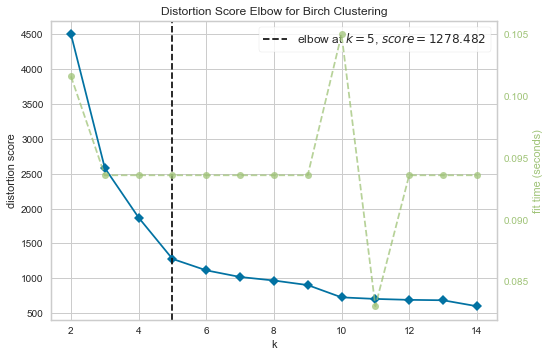

In [39]:
elbow_plot(Birch(), df3_log_scaler_pca)

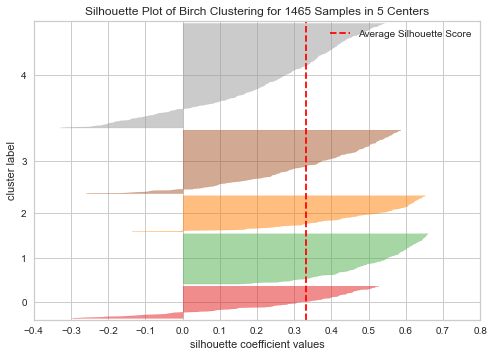

In [40]:
birch_pca = Birch(n_clusters = 5)
birch_pca.fit(df3_log_scaler_pca)
silhouette_plot(birch_pca, df3_log_scaler_pca)

Lepiej niż bez PCA, ale nadal występują ujemne współczynniki silhouette.

In [41]:
birch_pca_silhouette_avg = silhouette_score(df3_log_scaler_pca, birch_pca.labels_)
birch_pca_silhouette_avg

0.3313408134694622

In [42]:
birch_pca_sum = pd.Series(birch_pca.labels_).value_counts()
birch_pca_sum

4    534
3    325
1    257
2    184
0    165
dtype: int64

### 4.5. Agglomerative Clustering

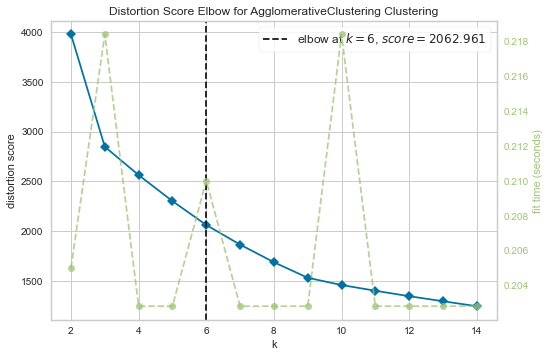

In [43]:
elbow_plot(AgglomerativeClustering(), df3_log_scaler)

Algorytm wskazał k = 6 jako najlepszy. Zatem nasze dane podzielimy na 6 grup.

In [44]:
ac = AgglomerativeClustering(n_clusters = 6)
ac.fit(df3_log_scaler)

ac_silhouette_avg = silhouette_score(df3_log_scaler, ac.labels_)
ac_silhouette_avg

0.22322447554998906

In [45]:
ac_sum = pd.Series(ac.labels_).value_counts()
ac_sum

2    459
1    326
3    234
0    211
4    126
5    109
dtype: int64

### 4.6. Agglomerative Clustering PCA (*bonus)

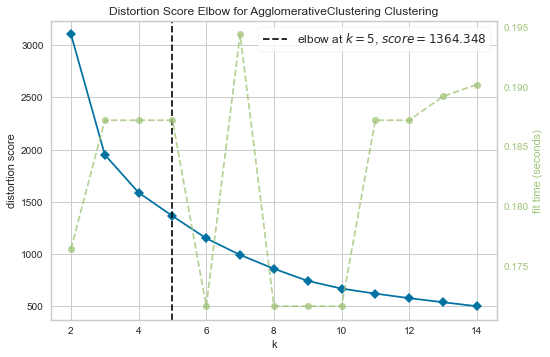

In [46]:
elbow_plot(AgglomerativeClustering(), df3_log_scaler_pca)

In [47]:
ac_pca = AgglomerativeClustering(n_clusters = 5)
ac_pca.fit(df3_log_scaler_pca)

ac_pca_silhouette_avg = silhouette_score(df3_log_scaler_pca, ac_pca.labels_)
ac_pca_silhouette_avg

0.3361907385648576

In [48]:
ac_pca_sum = pd.Series(ac_pca.labels_).value_counts()
ac_pca_sum

0    564
2    438
1    228
3    142
4     93
dtype: int64

### 4.7. Segmentacja hierarchiczna

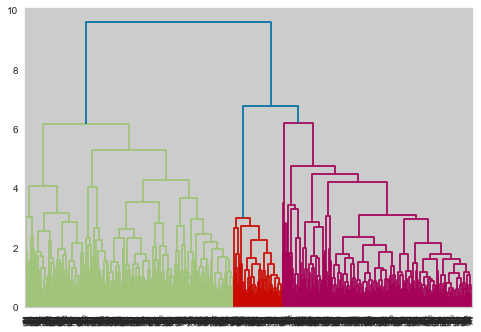

In [49]:
cl_mergings = linkage(df3_log_scaler, method = "complete")
dendrogram(cl_mergings)
plt.show()

Podzielimy dane na 3 grupy

In [50]:
sg_labels = fcluster(cl_mergings, 3, criterion = "maxclust")

In [51]:
sg_silhouette_avg = silhouette_score(df3_log_scaler, sg_labels)
sg_silhouette_avg

0.22887626069641565

In [52]:
sg_sum = pd.Series(sg_labels).value_counts()
sg_sum

1    684
3    620
2    161
dtype: int64

### 4.8. Segmentacja hierarchiczna PCA (*bonus)

In [53]:
cl_mergings_pca = linkage(df3_log_scaler_pca, method = "complete")

sg_pca_labels = fcluster(cl_mergings_pca, 3, criterion = "maxclust")

sg_pca_silhouette_avg = silhouette_score(df3_log_scaler_pca, sg_pca_labels)
sg_pca_silhouette_avg

0.28302589923283605

In [54]:
sg_pca_sum = pd.Series(sg_pca_labels).value_counts()
sg_pca_sum

3    791
1    524
2    150
dtype: int64

### 4.9. Podsumowanie segmentacji

In [55]:
sum_seg = pd.DataFrame(data = {"Silhouette Score": [k_means_silhouette_avg, k_means_pca_silhouette_avg, birch_silhouette_avg,
                                             birch_pca_silhouette_avg, ac_silhouette_avg, ac_pca_silhouette_avg, 
                                             sg_silhouette_avg, sg_pca_silhouette_avg],
                               "Liczba grup wyznaczona przez metodę łokcia": [kmeans_sum.size, kmeans_pca_sum.size, 
                                                                              birch_sum.size, birch_pca_sum.size,
                                                                              ac_sum.size, ac_pca_sum.size, sg_sum.size, 
                                                                              sg_pca_sum.size]
                              },
                       index = ["KMeans", "KMeans PCA", "Birch", "Birch PCA", "Agglomerative Clustering",
                               "Agglomerative Clustering PCA", "Segmentacja Hierarchiczna", "Segmentacja Hierarchiczna PCA"]
                       )
sum_seg.sort_values(by = "Silhouette Score", ascending = False)

,Silhouette Score,Liczba grup wyznaczona przez metodę łokcia
KMeans PCA,0.362761,5
Agglomerative Clustering PCA,0.336191,5
Birch PCA,0.331341,5
Segmentacja Hierarchiczna PCA,0.283026,3
KMeans,0.264361,5
Birch,0.237458,7
Segmentacja Hierarchiczna,0.228876,3
Agglomerative Clustering,0.223224,6


Najlepszy wynik Silhouette otrzymał model KMeans oparty na zredukowanych do dwu wymiarów danych, który podzielił dane na 5 grup. Ten model wybieramy do dalszej analizy.

## 5. Analiza segmentów

Zobaczmy jak rozkładają się na płaszczyźnie nasze dane podzielone na segmenty

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

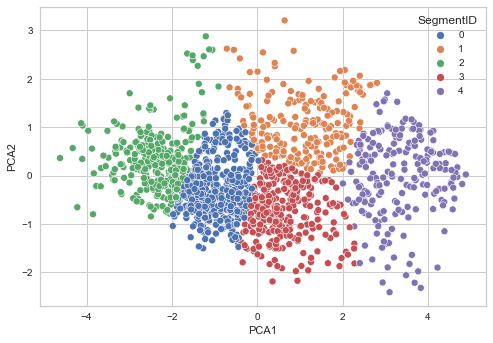

In [56]:
coordinates = pd.DataFrame(data = df3_log_scaler_pca, columns = ["PCA1", "PCA2"])
coordinates.loc[:, "SegmentID"] = kmeans_pca.labels_
sns.scatterplot(x = "PCA1", y = "PCA2", data = coordinates, hue = "SegmentID", palette = "deep")

Bardzo ładnie to wygląda :)

Utworzymy nową kolumnę, w której będą przechowywane identyfikatory grup.

In [57]:
df3_log_scaler.loc[:, "SegmentID"] = kmeans_pca.labels_

Zobaczmy, jak prezentują się zależności kolumn z podziałem na grupy.

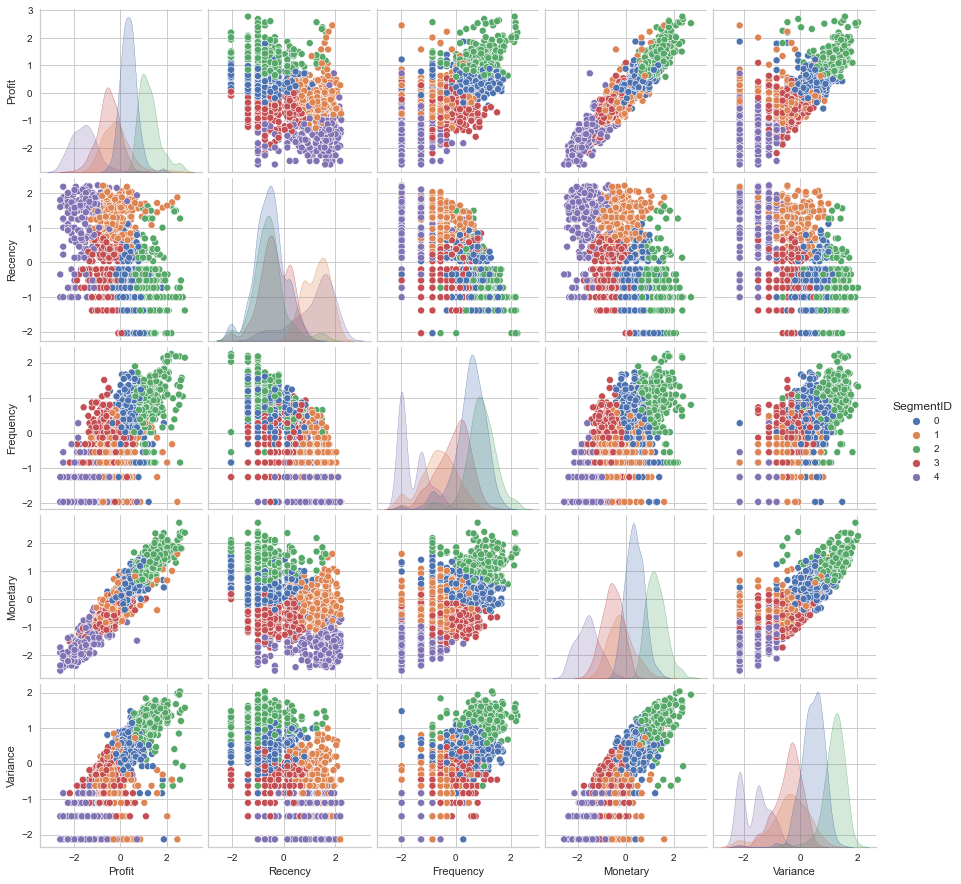

In [58]:
sns.pairplot(df3_log_scaler, hue = "SegmentID", palette = "deep")

In [59]:
df3_log_scaler.groupby(by = "SegmentID").mean()

,Profit,Recency,Frequency,Monetary,Variance
SegmentID,,,,,
0,0.341222,-0.549933,0.517760,0.371655,0.429322
1,-0.175603,1.270386,-0.635945,-0.189496,-0.381361
2,1.240776,-0.589070,0.909020,1.266753,1.187998
3,-0.526269,-0.356305,-0.098116,-0.573949,-0.421664
4,-1.580448,1.137872,-1.569348,-1.598203,-1.611784


Na podstawie pairplotów i powyższej tabeli przeanalizujmy poszczególne grupy:
- 0 (niebiescy): Klienci bardzo często powracający (ujemne Recency), kupujący dużo (Monetary i Variance), przynoszący korzyści sklepowi (Profit). ZAKUPOHOLIK POŻĄDANY
- 1 (pomarańczowi): Klienci najrzadziej powracający (najwyższe Recency), kupujący niezbyt wiele (ujemne Manetary i Variance). TURYSTA
- 2 (zieloni): Klienci z największymi korzyściami dla sklepu (najwyższy Profit), najczęściej składający zamówienia (najniższe Recency, najwyższe Frequency), zamawiający najwięcej różnych produktów (najwyższe Monetary i Variance). KLIENT JAK MARZENIE
- 3 (czerwoni): Do tej grupy należą klienci, których wartość zamówionych produktów jest niska (ujemne Monetary) i którzy kupują mało różnorodnych produktów (ujemne Variance). Jednak dosyć regularnie powracają i składają zamówienia (ujemne Recency). REGULARNY OSZCZĘDNY
- 4 (fioletowi): Tutaj mamy klientów, którzy bardzo mało kupują (najniższe Monetary i najniższe Variance) i bardzo rzadko (najniższe Frequency). Przynoszą najmniejsze korzyści dla sklepu (najniższe Profit). NIEPRZEKONANY

## 6. Zapisanie do pliku

Do pierwotnej tabeli dołączymy numer grupy uzyskany za pomocą algorytmu KMeans oraz nazwy tych grup utworzone powyżej.

In [60]:
# Łączę tabele i usuwam niepotrzebne kolumny

df_final = pd.concat([df3_log_scaler, df2], axis = 1, ignore_index = True).drop([0,1,2,3,4], axis = 1)

# Nadaję kolumnom nazwy

df_final.columns = ["SegmentID", "CustomerID", "Profit", "Recency", "Frequency", "Monetary", "Variance"]

# Wypełniam nulle w kolumnie "SegmentID" 
# (rekordów jest więcej niż w kolumnie "SegmentID", ponieważ usunęliśmy wartości odstające)

df_final.SegmentID = df_final.SegmentID.fillna('outlier')

# Przestawiam kolumnę "SegmentID" na koniec tabeli

df_final = pd.DataFrame(df_final, columns = ["CustomerID", "Profit", "Recency", "Frequency", "Monetary", "Variance", "SegmentID"])

# Dodaję nazwy grup

df_final.loc[df_final.SegmentID == 0, "SegmentName"] = "Zakupoholik pożądany"
df_final.loc[df_final.SegmentID == 1, "SegmentName"] = "Turysta"
df_final.loc[df_final.SegmentID == 2, "SegmentName"] = "Klient jak marzenie"
df_final.loc[df_final.SegmentID == 3, "SegmentName"] = "Regularny Oszczędny"
df_final.loc[df_final.SegmentID == 4, "SegmentName"] = "Nieprzekonany"
df_final.loc[df_final.SegmentID == 'outlier', "SegmentName"] = "outlier"

In [61]:
df_final.sample(5, random_state = 35)

,CustomerID,Profit,Recency,Frequency,Monetary,Variance,SegmentID,SegmentName
298,299,132,19,2,"759,92",2,4.0,Nieprzekonany
703,704,87,56,5,"1863,75",6,1.0,Turysta
1242,1243,457,3,14,"11091,38",18,0.0,Zakupoholik pożądany
238,239,36,9,3,"783,37",5,3.0,Regularny Oszczędny
534,535,997,6,15,"54749,65",48,2.0,Klient jak marzenie


Zapisujemy DataFrame do pliku

In [62]:
df_final.to_csv("customers.csv", index = False)

Na koniec zobaczmy, jak wyglądają pairploty naszych oryginalnych danych z podziałem na grupy.

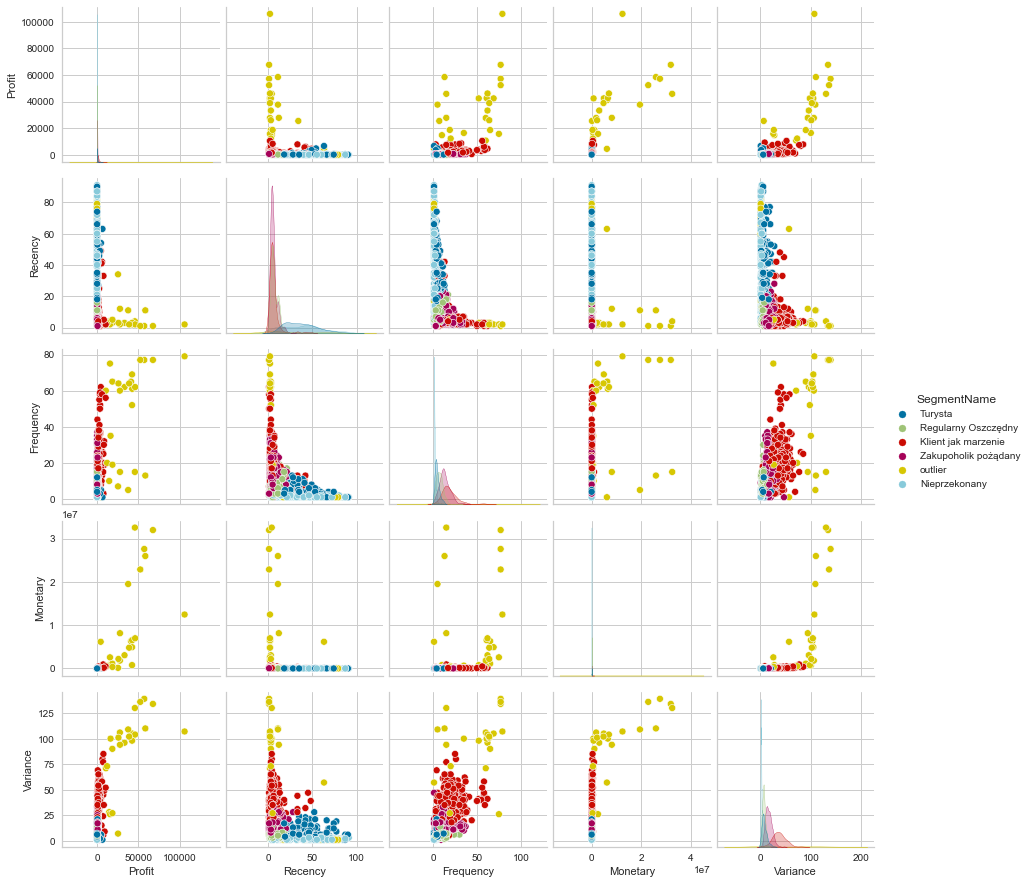

In [63]:
df_org = pd.concat([df3, df_final.SegmentName], axis = 1)
sns.pairplot(df_org, hue = "SegmentName")

Bardzo ładnie widać outliersy :)

## 7. Podsumowanie

- wczytanie danych
- sprawdzenie kolumn:
    - ilość wierszy i kolumn
    - brakujące wartości
    - typy
- przygotowanie danych do segmentacji:
    - konwersja kolumn na liczby
    - usunięcie niepotrzebnej kolumny CustomerID
    - logarytmizacja
    - usunięcie wartości odstających
    - standaryzacja (niezbędna do PCA)
    - sprawdzenie zależności liniowych (korelacje)
    - redukcja wymiarów (PCA)
- segmentacja (liczba segmentów na podstawie metody łokcia):
    - KMeans (x2)
    - Birch (x2)
    - Agglomerative Clastering (x2)
    - Segmentacja hierarchiczna (x2)
    - wybranie najlepszego modelu na podstawie wyniku Silhouette)
- analiza segmentów:
    - rozkład danych na płaszczyźnie
    - dodanie numeru segmentu do danych
    - dodanie nazwy segmentu na podstawie ich charakterystyk
- zapisanie pliku z nowymi kolumnami